In [21]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams.update({
    'figure.dpi' : 150
})




In [302]:
test_survived = pd.read_csv('gender_submission.csv')
test_set = pd.read_csv('test.csv').merge(test_survived, on='PassengerId')
train_set = pd.read_csv('train.csv')
dfs = [train_set, test_set]

remapper = {
    'Survived' : {
        0 : 'Died',
        1 : 'Survived'
    }
}
[df.replace(remapper, inplace= True) for df in dfs]

total_set = pd.concat(dfs)

dfs = {i : eval(i).reset_index() for i in ['train_set', 'test_set', 'total_set']}
total_df = pd.concat(dfs, axis =0).drop(columns='index')


# Meaning of columns:

| Column Name | Meaning | Values |
|---|---|---|
| Survived | If survived | 0 = No, 1 = Yes |
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex | sex | Male / Female |
| Age | Age in years | xx.5 = guess, 0.?? months (float) |
| Sibsp | Number of siblings / spouses aboard | int |
| Parch | Number of parents / children aboard | int | 
| Ticket | Ticket number | string |
| Fare | Passenger fare | float |
| Cabin | Cabin number | string |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

Survived
Died        Axes(0.125,0.11;0.775x0.77)
Survived    Axes(0.125,0.11;0.775x0.77)
dtype: object

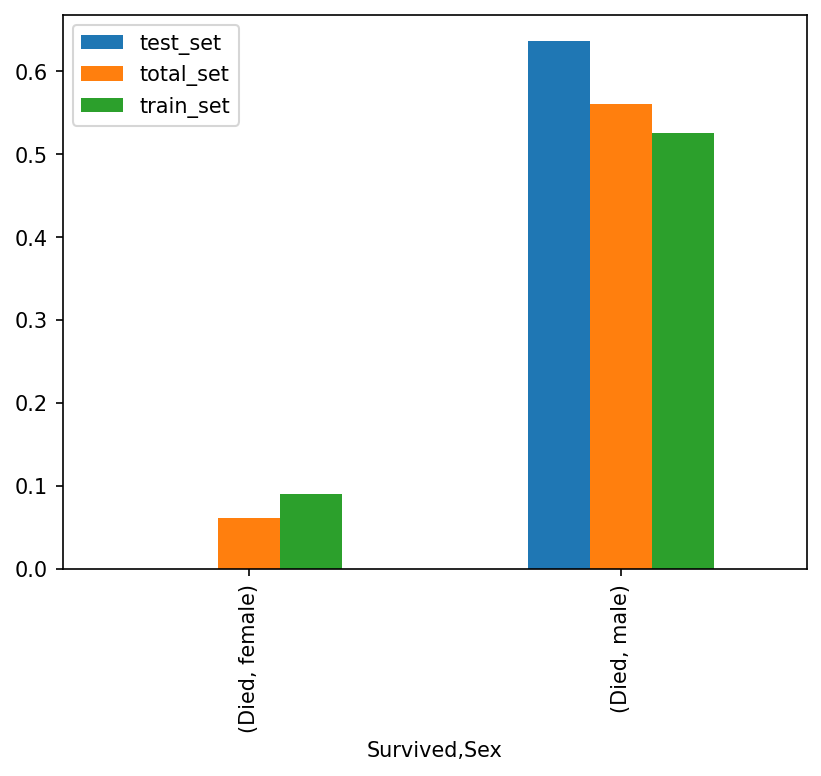

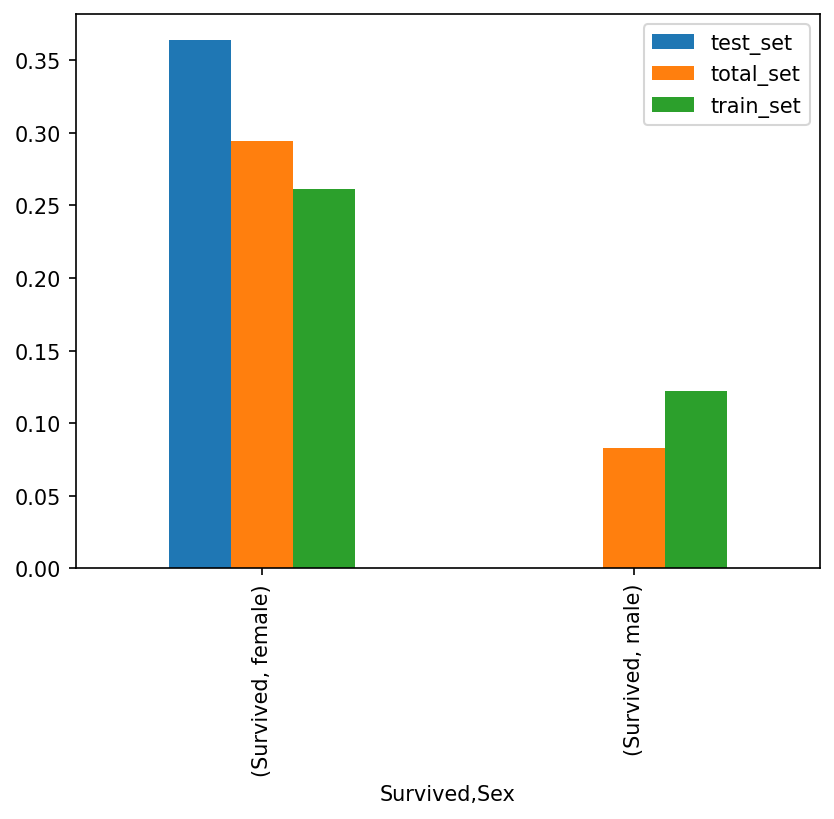

In [340]:
survived_percent = total_df.groupby(level=0)[['Survived', 'Sex']].value_counts(normalize=True).unstack(level=0)
ax = survived_percent.groupby(level = 0).plot(kind='bar')
ax
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = 'right')

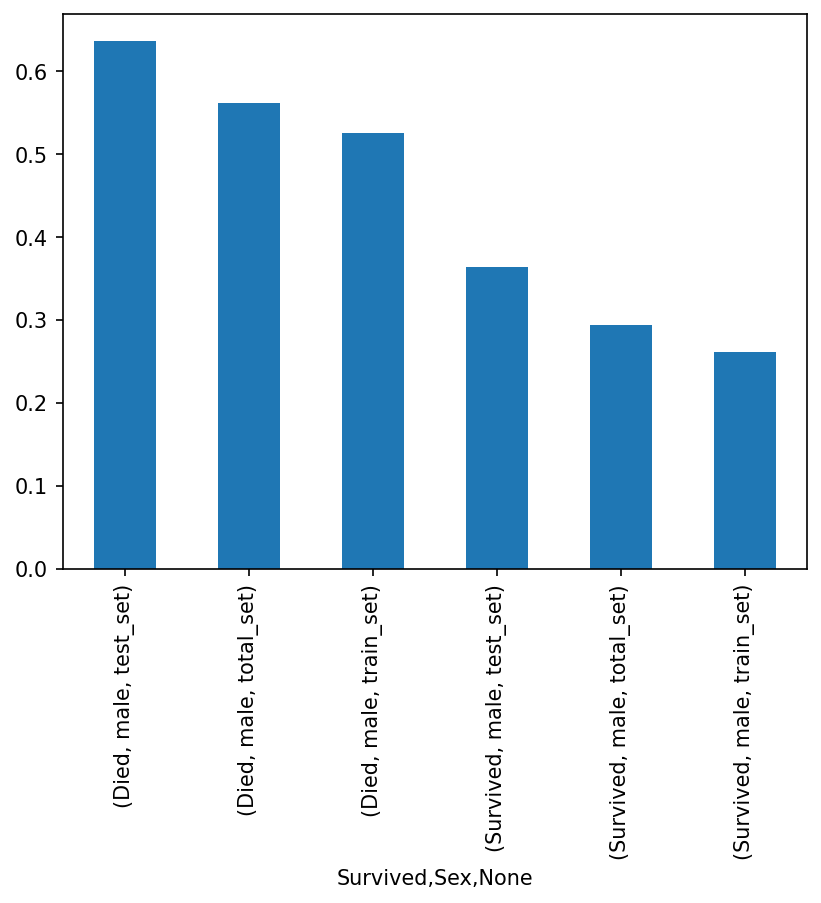

In [378]:
a = survived_percent.T.unstack(level=0).groupby('Sex').plot(kind = 'bar')

In [305]:
total_df.index.names

FrozenList([None, None])

Sex
female    Axes(0.125,0.11;0.775x0.77)
male      Axes(0.125,0.11;0.775x0.77)
dtype: object

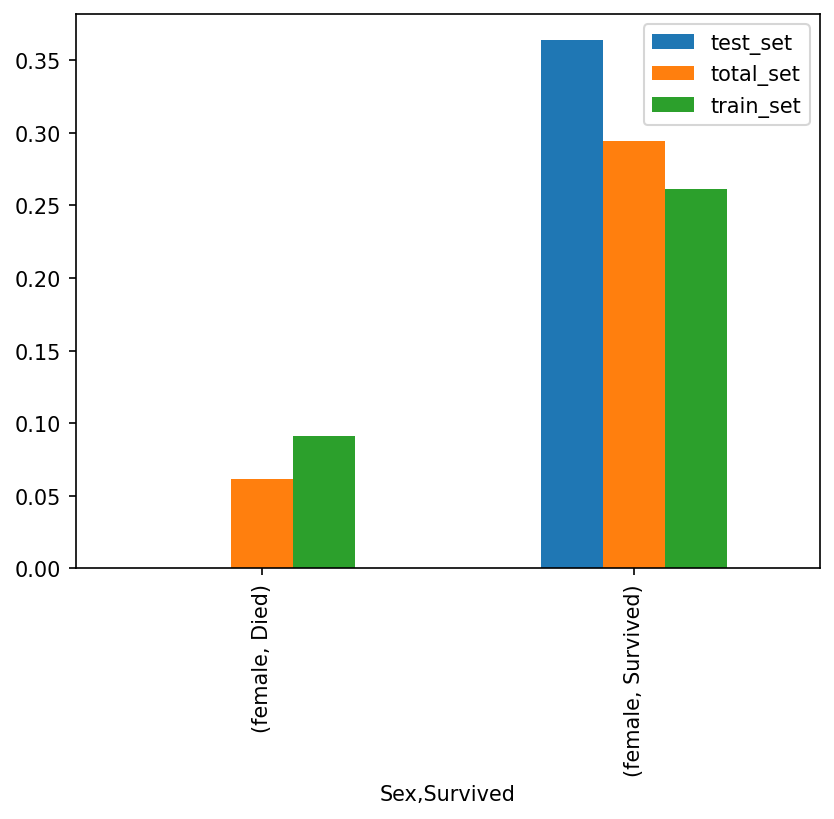

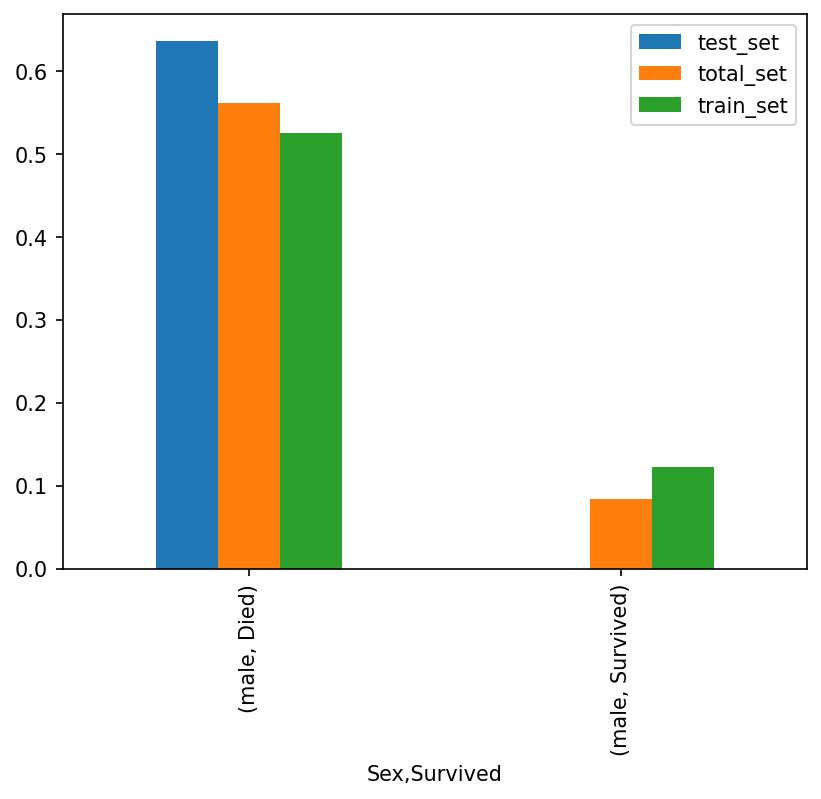

In [333]:
ax = total_df.groupby(level=0)[['Sex', 'Survived']].value_counts(normalize=True)\
        .unstack(level=0).groupby(level=0)\
        .plot(kind='bar')
        
ax
